# References

### [sklearn]
- https://www.kaggle.com/mchirico/quick-look-seaborn-wordcloud
- https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

### [pytorch]
- https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from io import StringIO
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from text_processing import text_preprocessing
from wordcloud import WordCloud

# Data Preparation

- train-test split
- batch-loading
- data preparation for MIMIC from postgres
- null handling = sMOTE or other conventional methods
- auxilliary data for netflix needs to be collected

### Dataset 01: MIMIC
- predict the survival

In [3]:
df_data = pd.read_csv('data/patients_join_admissions.csv')
df_data.fillna('na', axis=1, inplace=True)
df_data.head(3)

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id.1,subject_id.1,...,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,1,2,M,2138-07-17 00:00:00,na,na,na,0,1,2,...,Private,na,NOT SPECIFIED,na,ASIAN,na,na,NEWBORN,0,1
1,2,3,M,2025-04-11 00:00:00,2102-06-14 00:00:00,na,2102-06-14 00:00:00,1,2,3,...,Medicare,na,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,3,4,F,2143-05-12 00:00:00,na,na,na,0,3,4,...,Private,na,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1


In [4]:
len_prev = len(df_data)
df_data.drop([
    'row_id', 
    'row_id.1', 
    'subject_id', 
    'subject_id.1',
    'dod',
    'dod_hosp',
    'dod_ssn',
    'hadm_id',
], axis=1, inplace=True)
len_curr = len(df_data)
print("{} rows with null values dropped".format(len_prev-len_curr))
print("{} rows of data available".format(len_curr))

0 rows with null values dropped
58976 rows of data available


In [5]:
df_data.head(10)

,gender,dob,expire_flag,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,M,2138-07-17 00:00:00,0,2138-07-17 19:04:00,2138-07-21 15:48:00,na,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,NOT SPECIFIED,na,ASIAN,na,na,NEWBORN,0,1
1,M,2025-04-11 00:00:00,1,2101-10-20 19:08:00,2101-10-31 13:58:00,na,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,na,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,F,2143-05-12 00:00:00,0,2191-03-16 00:28:00,2191-03-23 18:41:00,na,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,na,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,M,2103-02-02 00:00:00,0,2103-02-02 04:31:00,2103-02-04 12:15:00,na,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,BUDDHIST,na,ASIAN,na,na,NEWBORN,0,1
4,F,2109-06-21 00:00:00,0,2175-05-30 07:15:00,2175-06-15 16:00:00,na,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,na,na,CHRONIC RENAL FAILURE/SDA,0,1
5,F,2121-05-23 00:00:00,0,2121-05-23 15:05:00,2121-05-27 11:57:00,na,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,CATHOLIC,na,WHITE,na,na,NEWBORN,0,1
6,M,2117-11-20 00:00:00,0,2117-11-20 10:22:00,2117-11-24 14:20:00,na,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,CATHOLIC,na,WHITE,na,na,NEWBORN,0,1
7,M,2108-01-26 00:00:00,1,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,na,UNOBTAINABLE,na,UNKNOWN/NOT SPECIFIED,2149-11-09 11:13:00,2149-11-09 13:18:00,HEMORRHAGIC CVA,1,1
8,F,2103-06-28 00:00:00,0,2103-06-28 11:36:00,2103-07-06 12:10:00,na,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Medicaid,na,UNOBTAINABLE,na,BLACK/AFRICAN AMERICAN,na,na,NEWBORN,0,1
9,F,2128-02-22 00:00:00,1,2178-04-16 06:18:00,2178-05-11 19:00:00,na,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,na,OTHER,MARRIED,WHITE,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,0,1


### Text Preprocessing
- making text case insensitive
- handling special characters
- can possibly help match more columns in case of noisy data 
- standardize the categorical columns to prevent more dummy variables.

In [6]:
for col in [
    'dob',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
]:
    df_data[col][df_data[col]=='na'] = pd.Timestamp('18000101')
    df_data[col+"_year"] = pd.DatetimeIndex(df_data[col]).year
    df_data[col+"_month"] = pd.DatetimeIndex(df_data[col]).month
    df_data[col+"_day"] = pd.DatetimeIndex(df_data[col]).day
    df_data.drop(col, axis=1, inplace=True)

In [7]:
df_data.head()

,gender,expire_flag,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,...,dischtime_day,deathtime_year,deathtime_month,deathtime_day,edregtime_year,edregtime_month,edregtime_day,edouttime_year,edouttime_month,edouttime_day
0,M,0,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,NOT SPECIFIED,na,ASIAN,...,21,1800,1,1,1800,1,1,1800,1,1
1,M,1,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,na,CATHOLIC,MARRIED,WHITE,...,31,1800,1,1,2101,10,20,2101,10,20
2,F,0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,na,PROTESTANT QUAKER,SINGLE,WHITE,...,23,1800,1,1,2191,3,15,2191,3,16
3,M,0,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,BUDDHIST,na,ASIAN,...,4,1800,1,1,1800,1,1,1800,1,1
4,F,0,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,...,15,1800,1,1,1800,1,1,1800,1,1


In [8]:
for col in [
    'admission_type', 
    'admission_location', 
    'discharge_location', 
    'insurance',
    'religion',
    'marital_status',
    'ethnicity',
    'diagnosis',
]:
    df_data[col] = list(map(text_preprocessing, df_data[col].tolist()))
df_data.head(3)

,gender,expire_flag,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,...,dischtime_day,deathtime_year,deathtime_month,deathtime_day,edregtime_year,edregtime_month,edregtime_day,edouttime_year,edouttime_month,edouttime_day
0,M,0,newborn,phys referral normal deli,home,private,na,not specified,na,asian,...,21,1800,1,1,1800,1,1,1800,1,1
1,M,1,emergency,emergency room admit,snf,medicare,na,catholic,married,white,...,31,1800,1,1,2101,10,20,2101,10,20
2,F,0,emergency,emergency room admit,home with home iv providr,private,na,protestant quaker,single,white,...,23,1800,1,1,2191,3,15,2191,3,16


### Visualizations

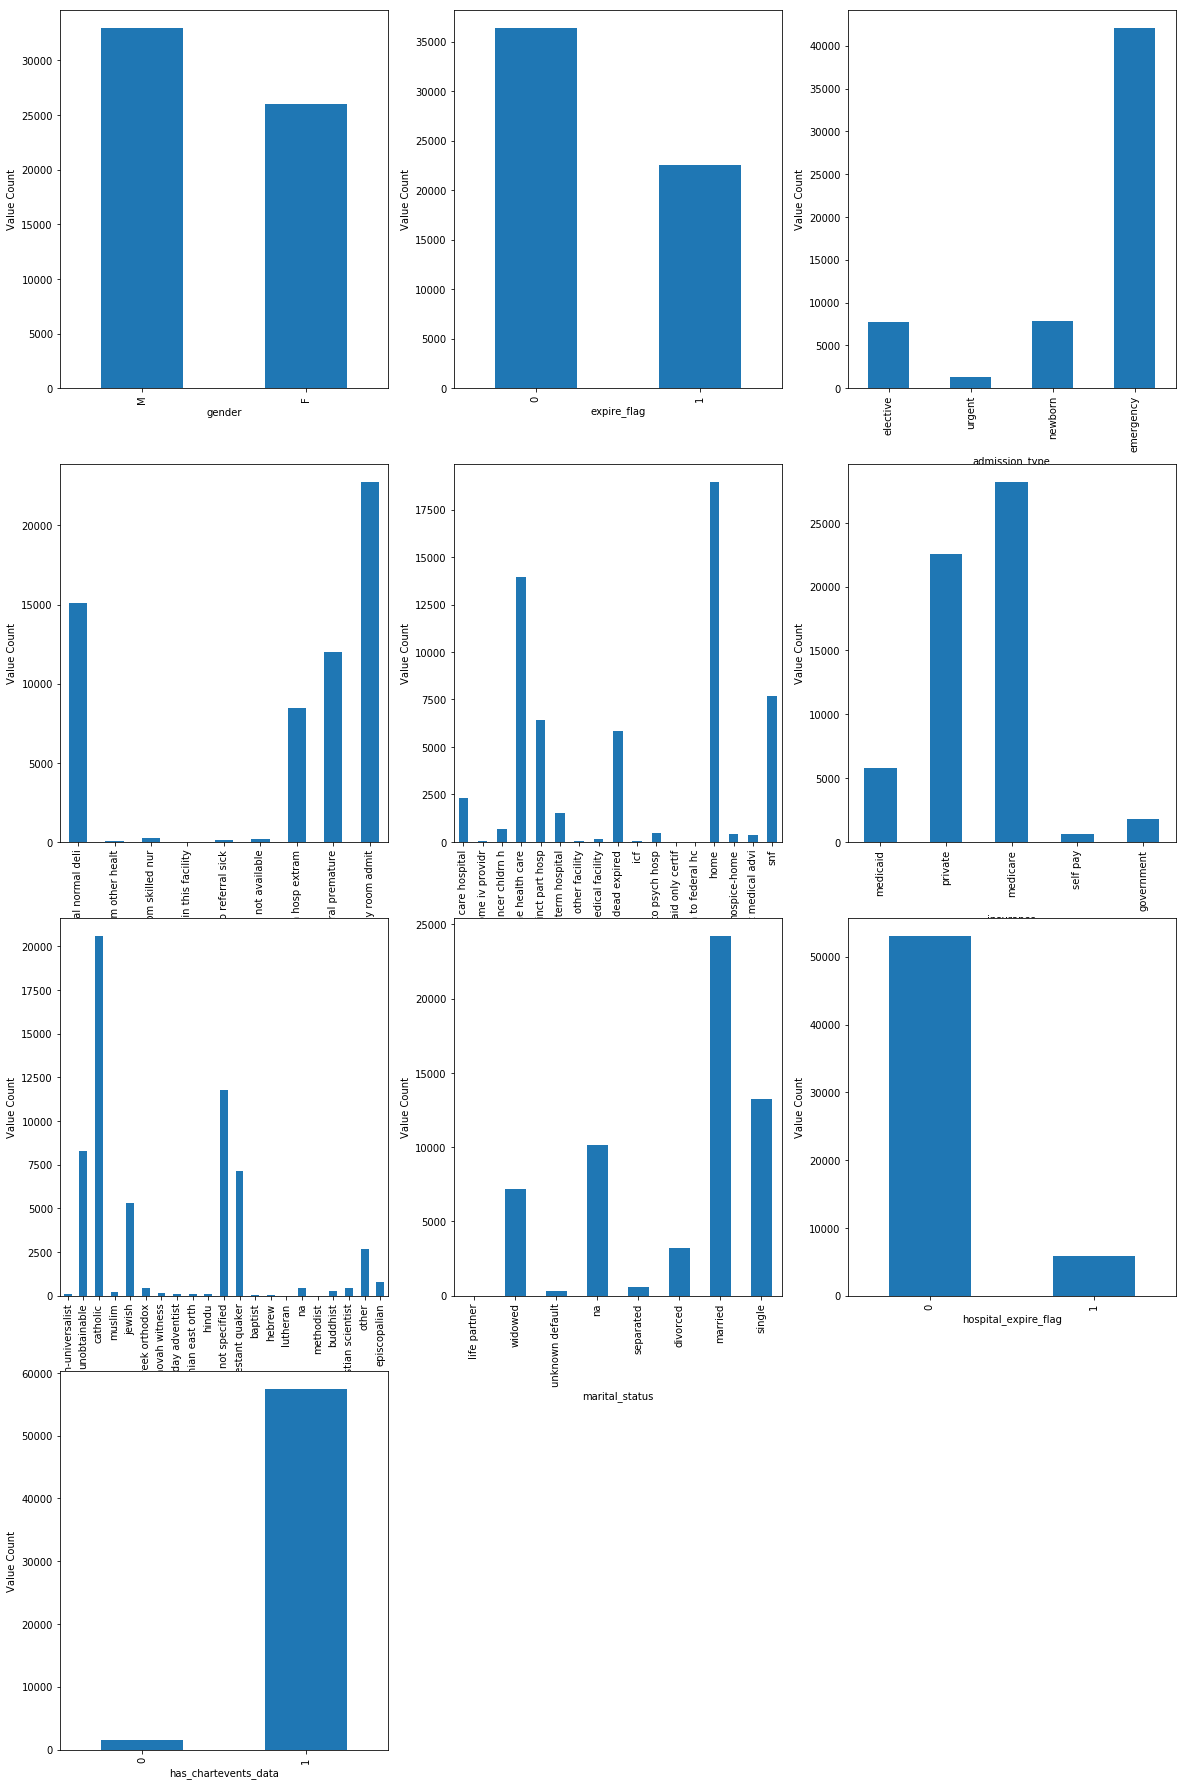

In [9]:
categorical_columns = [
    'gender',
    'expire_flag',
    'admission_type', 
    'admission_location', 
    'discharge_location', 
    'insurance', 
    'religion',
    'marital_status',
    'hospital_expire_flag',
    'has_chartevents_data',
]

num_cols = 3
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 8*num_rows))

for col in range(len(categorical_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[categorical_columns[col]].value_counts(sort=False).plot(kind='bar')
    plt.xlabel(categorical_columns[col])
    plt.ylabel('Value Count')
plt.show()

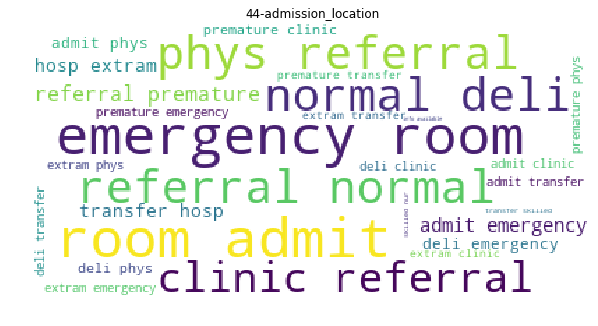

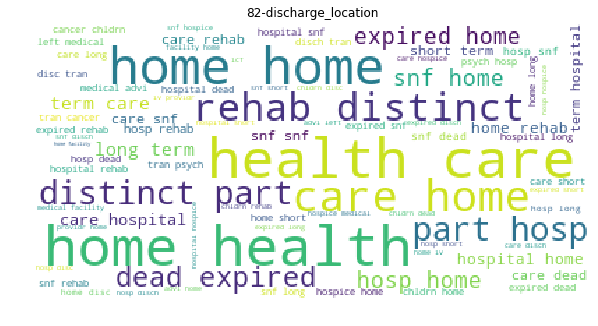

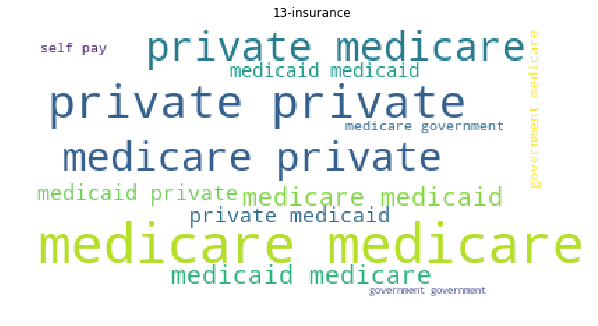

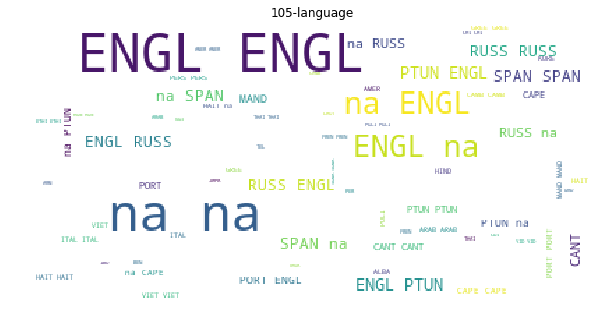

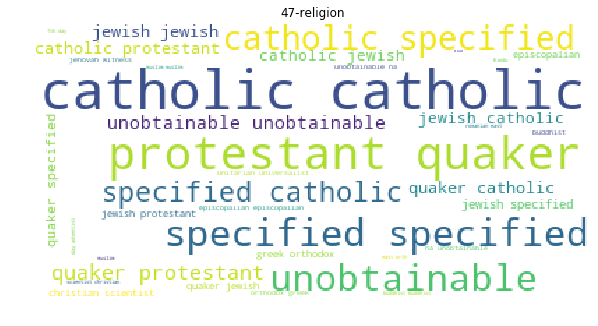

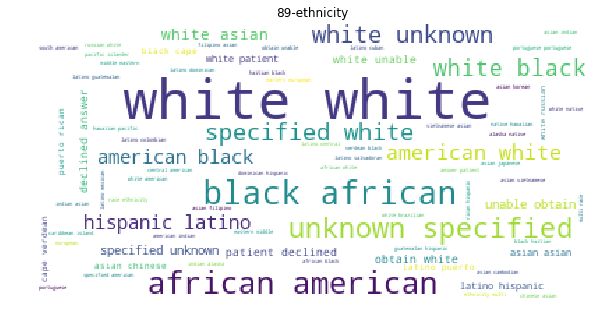

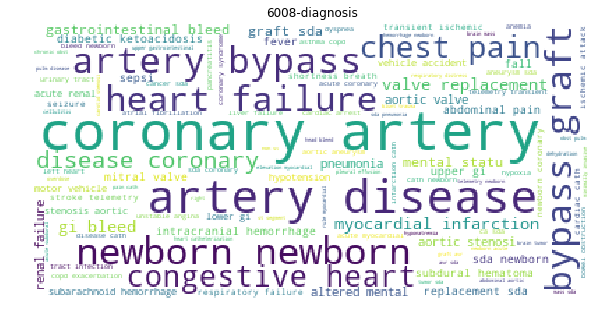

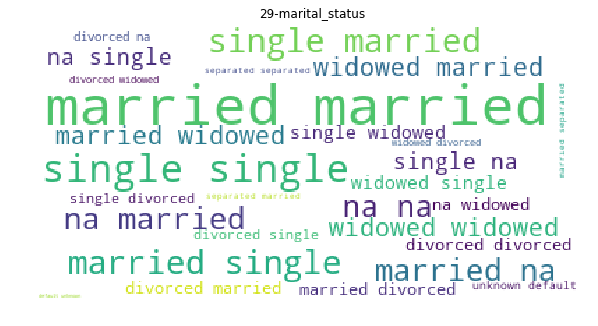

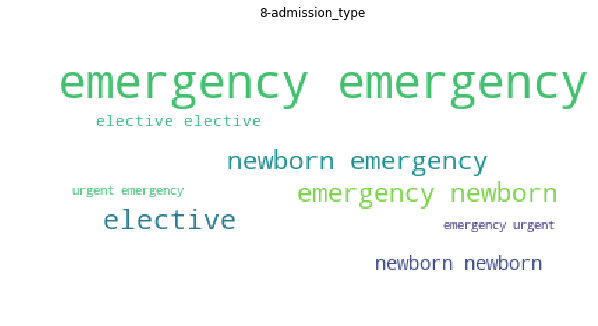

In [10]:
text_columns = [
    'admission_location', 
    'discharge_location', 
    'insurance', 
    'language', 
    'religion', 
    'ethnicity', 
    'diagnosis',
    'marital_status',
    'admission_type'
]

for col in range(len(text_columns)):
    si=StringIO()
    df_data[text_columns[col]].apply(lambda x: si.write(str(x) + " "))
    text=si.getvalue()
    si.close()

    wordcloud = WordCloud(width=1600, height=1600, max_words=100).generate(text)
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40, 
        relative_scaling=.5
    ).generate(text)
    plt.figure(figsize=(10, 20))
    plt.imshow(wordcloud)
    plt.title("{}-{}".format(str(len(wordcloud.words_)), text_columns[col]))
    plt.axis("off")
    plt.show()

### Definition of Ally and Adversary Variables.
- Ally target: Survived
- Adversary target: Sex
- The choice of adversary target can be changed.
- Chosen M/F here as it will be possible to have train-test split or k-fold validation

In [11]:
df_data = pd.get_dummies(df_data, columns=['gender'], drop_first=True)
df_data = pd.get_dummies(df_data, columns=[
    'admission_location', 
    'discharge_location',
    'insurance', 
    'language', 
    'religion', 
    'ethnicity',
    'marital_status',
    'admission_type'
])
df_data.head()

,expire_flag,diagnosis,hospital_expire_flag,has_chartevents_data,dob_year,dob_month,dob_day,admittime_year,admittime_month,admittime_day,...,marital_status_married,marital_status_na,marital_status_separated,marital_status_single,marital_status_unknown default,marital_status_widowed,admission_type_elective,admission_type_emergency,admission_type_newborn,admission_type_urgent
0,0,newborn,0,1,2138,7,17,2138,7,17,...,0,1,0,0,0,0,0,0,1,0
1,1,hypotension,0,1,2025,4,11,2101,10,20,...,1,0,0,0,0,0,0,1,0,0
2,0,fever dehydration failure to thrive,0,1,2143,5,12,2191,3,16,...,0,0,0,1,0,0,0,1,0,0
3,0,newborn,0,1,2103,2,2,2103,2,2,...,0,1,0,0,0,0,0,0,1,0
4,0,chronic renal failure sda,0,1,2109,6,21,2175,5,30,...,1,0,0,0,0,0,1,0,0,0


In [12]:
y_ally = np.array(df_data.expire_flag.tolist())
y_advr = np.array(df_data.gender_M.tolist())

df_data.drop(['expire_flag', 'gender_M'], axis=1, inplace=True)

- using One hot encoding to convert the categorical data into dummy variables.
- Alternatively: [Managing categorical variables in pandas dataframe](http://benalexkeen.com/mapping-categorical-data-in-pandas/)
- Using count vectorizer to convert the text data into features based on bow model.

In [13]:
vectorizer = CountVectorizer(vocabulary=wordcloud.words_.keys())
diagnosis = vectorizer.fit_transform(df_data.diagnosis.tolist()).toarray()

In [14]:
df_data.drop(['diagnosis'], axis=1, inplace=True)
df_data.head(3)

,hospital_expire_flag,has_chartevents_data,dob_year,dob_month,dob_day,admittime_year,admittime_month,admittime_day,dischtime_year,dischtime_month,...,marital_status_married,marital_status_na,marital_status_separated,marital_status_single,marital_status_unknown default,marital_status_widowed,admission_type_elective,admission_type_emergency,admission_type_newborn,admission_type_urgent
0,0,1,2138,7,17,2138,7,17,2138,7,...,0,1,0,0,0,0,0,0,1,0
1,0,1,2025,4,11,2101,10,20,2101,10,...,1,0,0,0,0,0,0,1,0,0
2,0,1,2143,5,12,2191,3,16,2191,3,...,0,0,0,1,0,0,0,1,0,0


In [15]:
X = np.concatenate((df_data.values, diagnosis), axis=1)
y_ally.shape, y_advr.shape, X.shape

((58976,), (58976,), (58976, 209))

# Checkpoint

In [16]:
import pickle as pkl

pkl.dump((X, y_ally, y_advr), open('checkpoints/mimic_processed_data_X_y_ally_y_advr.pkl', 'wb'))

In [3]:
import pickle as pkl

X, y_ally, y_advr = pkl.load(open('checkpoints/mimic_processed_data_X_y_ally_y_advr.pkl', 'rb'))

### Train Test Split

- This step is required before the Scaling or PCA is learnt on the train dataset and then used to transform the test dataset.

In [4]:
X_train, X_valid, y_ally_train, y_ally_valid, y_advr_train, y_advr_valid = train_test_split(
    X, 
    y_ally,
    y_advr,
    test_size=0.1,
    stratify=pd.DataFrame(np.concatenate((y_ally.reshape(-1, 1), y_advr.reshape(-1, 1)), axis=1))
)
X_train.shape, X_valid.shape, y_ally_train.shape, y_ally_valid.shape, y_advr_train.shape, y_advr_valid.shape

((53078, 209), (5898, 209), (53078,), (5898,), (53078,), (5898,))

### Checking the distribution after the split

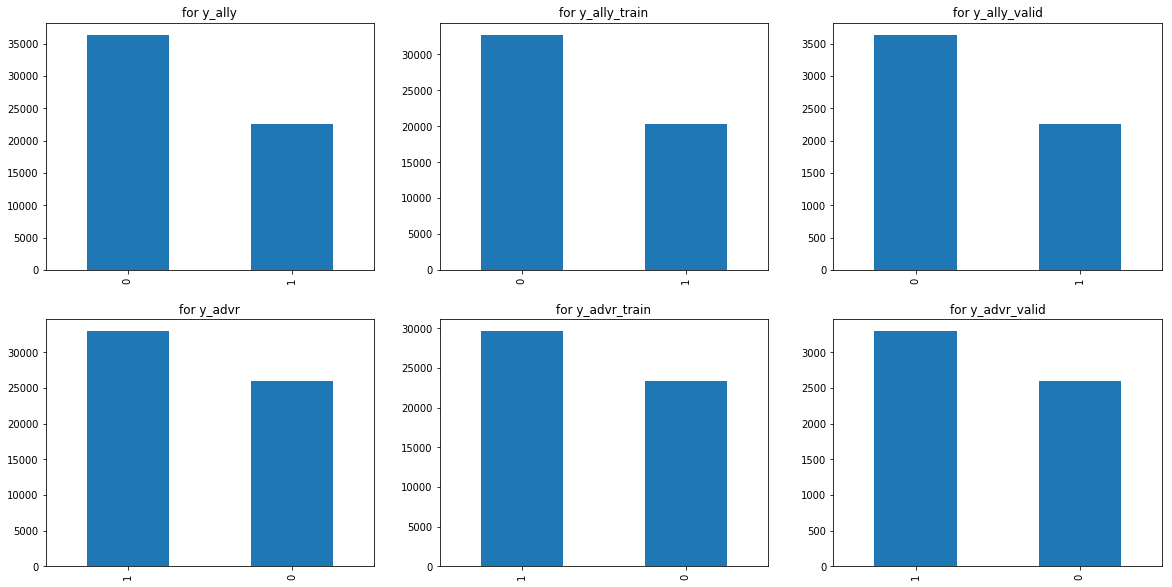

In [17]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
pd.value_counts(y_ally).plot(kind='bar')
plt.title('for y_ally')
plt.subplot(2, 3, 2)
pd.value_counts(y_ally_train).plot(kind='bar')
plt.title('for y_ally_train')
plt.subplot(2, 3, 3)
pd.value_counts(y_ally_valid).plot(kind='bar')
plt.title('for y_ally_valid')
plt.subplot(2, 3, 4)
pd.value_counts(y_advr).plot(kind='bar')
plt.title('for y_advr')
plt.subplot(2, 3, 5)
pd.value_counts(y_advr_train).plot(kind='bar')
plt.title('for y_advr_train')
plt.subplot(2, 3, 6)
pd.value_counts(y_advr_valid).plot(kind='bar')
plt.title('for y_advr_valid')
plt.show()

### Scaler
- Perform minmax scaling for removing the skewness which might effect the gradient descent during neural network training. 
- It is necessary to do this scaling before PCA is applied

In [5]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)

### Apply PCA and select components using explained variances

In [6]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_normalized)

In [7]:
num_components = 0
total_var = 0
variance_threshold = 0.99
for _ in pca.explained_variance_ratio_:
    total_var += _
    num_components += 1
    if total_var > variance_threshold:
        break
print(total_var, num_components)

0.9911379840611416 176


In [8]:
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_normalized)
X_valid_reduced = pca.transform(X_valid_normalized)
X_train_reduced.shape, X_valid_reduced.shape

((53078, 176), (5898, 176))

### Apply Auto-encoders for dimensionality reduction

In [9]:
import torch
import torch.utils.data as utils
import torch.nn as nn

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

DType: torch.float32
Cuda available: True
Device: cuda


In [14]:
dataset_train = utils.TensorDataset(torch.Tensor(X_train_normalized))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=False, num_workers=2)

dataset_valid = utils.TensorDataset(torch.Tensor(X_valid_normalized))
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)

In [12]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.relu(self.fc1(x))

    def decoder(self, y):
        return self.sigmoid(self.fc2(y))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [13]:
auto_encoder = AutoEncoder(input_size=X_train_normalized.shape[1], encoding_dim=X_train_reduced.shape[1]).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.0001)

In [15]:
print("epoch \t Aencoder_train \t Aencoder_valid")

ae_epoch = []
ae_train = []
ae_valid = []

auto_encoder.train()

for epoch in range(101):
    for i, data_train in enumerate(dataloader_train, 0):
        X_train_torch = data_train[0].to(device)
        ae_optimizer.zero_grad()
    
        X_train_torch_hat = auto_encoder(X_train_torch)
        ae_loss = criterion(X_train_torch_hat, X_train_torch)
        ae_loss.backward()
        ae_optimizer.step()
    
    if epoch%10!=0:
        continue
        
    nsamples = 0
    ae_valid_loss = 0
    
    for j, data_valid in enumerate(dataloader_valid, 0):
        X_valid_torch = data_valid[0].to(device)
        X_valid_torch_hat = auto_encoder(X_valid_torch)
        ae_valid_loss += criterion(X_valid_torch_hat, X_valid_torch)
        nsamples += 1
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_valid_loss/nsamples
    ))
    
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    ae_valid.append(ae_valid_loss/nsamples)

epoch 	 Aencoder_train 	 Aencoder_valid
0 	 0.76296526 	 0.93813688
10 	 0.61314511 	 0.79001606
20 	 0.60933232 	 0.78566033
30 	 0.60862613 	 0.78420407
40 	 0.60839498 	 0.78390354
50 	 0.60830927 	 0.78373045
60 	 0.60825771 	 0.78365070
70 	 0.60821557 	 0.78356630
80 	 0.60818374 	 0.78354824
90 	 0.60815996 	 0.78354138
100 	 0.60814077 	 0.78353649


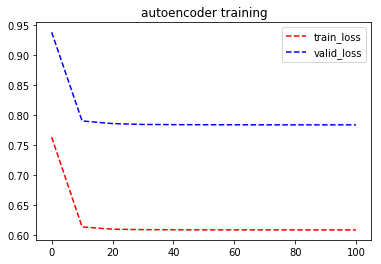

In [16]:
plt.plot(ae_epoch, ae_train, 'r--')
plt.plot(ae_epoch, ae_valid, 'b--')
plt.legend(['train_loss', 'valid_loss'])
plt.title("autoencoder training")
plt.show()

In [38]:
torch.save(auto_encoder, 'checkpoints/mimic_auto_encoder.pkl')

# GAN using Pytorch

- ["**Learning Informative and Private Representations via Generative Adversarial Networks**"](http://www.princeton.edu/~pmittal/publications/gan-bigdata18.pdf)

### GAN V1

```python
encd_N = 64 
encd_D_in = X.shape[1]
encd_H = int(encd_D_in/2)
encd_D_out = 64

# encoder
encd_w1 = torch.randn(encd_D_in, encd_H, device=device, dtype=dtype, requires_grad=True)
encd_w2 = torch.randn(encd_H, encd_D_out, device=device, dtype=dtype, requires_grad=True)

ally_N = 64 
ally_D_in = encd_D_out
ally_H = int(ally_D_in/2)
ally_D_out = 1

# ally
ally_w1 = torch.randn(ally_D_in, ally_H, device=device, dtype=dtype, requires_grad=True)
ally_w2 = torch.randn(ally_H, ally_D_out, device=device, dtype=dtype, requires_grad=True)

advr_N = 64 
advr_D_in = encd_D_out
advr_H = int(advr_D_in/2)
advr_D_out = 2

# advr
advr_w1 = torch.randn(advr_D_in, advr_H, device=device, dtype=dtype, requires_grad=True)
advr_w2 = torch.randn(advr_H, advr_D_out, device=device, dtype=dtype, requires_grad=True)
```

### GAN V2

In [10]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [11]:
def train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True):
    encoding_dimension = X_train_reduced.shape[1]
    encoder = Encoder(input_size=X_train_normalized.shape[1], hidden_size=1024, output_size=encoding_dimension).cuda()
    ally = Ally(input_size=encoding_dimension, hidden_size=128, output_size=1).cuda()
    adversary = Adversary(input_size=encoding_dimension, hidden_size=128, output_size=1).cuda()

    dataset_train = utils.TensorDataset(
        torch.Tensor(X_train_normalized), 
        torch.Tensor(y_ally_train.reshape(-1, 1)),
        torch.Tensor(y_advr_train.reshape(-1, 1)))
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=False, num_workers=2)

    dataset_valid = utils.TensorDataset(
        torch.Tensor(X_valid_normalized),
        torch.Tensor(y_ally_valid.reshape(-1, 1)),
        torch.Tensor(y_advr_valid.reshape(-1, 1))
    )
    dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)

    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    encd_optimizer = optimizer(encoder.parameters(), lr = lr_encd)
    ally_optimizer = optimizer(ally.parameters(), lr=lr_ally)
    advr_optimizer = optimizer(adversary.parameters(), lr=lr_advr)

    if debug:
        print("epoch \t encoder_train \t encoder_valid \t ally_train \t ally_valid \t advr_train \t advr_valid")

    g_epoch = []
    enc_train = []
    enc_valid = []
    ally_train = []
    ally_valid = []
    advr_train = []
    advr_valid = []

    
    encoder.train()
    ally.train()
    adversary.train()
    
    for epoch in range(n_iter_gan):
        # set for training
        for i, data in enumerate(dataloader_train, 0):
            X_train_torch = data[0].to(device)
            y_ally_train_torch = data[1].to(device)
            y_advr_train_torch = data[2].to(device)
            encd_optimizer.zero_grad()
            # Forward passv
            X_train_encoding = encoder(X_train_torch)
            y_ally_train_torch_hat = ally(X_train_encoding)
            y_advr_train_torch_hat = adversary(X_train_encoding)
            # Compute Loss
            ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
            advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
            encd_loss = alpha * ally_loss - (1-alpha) * advr_loss
            # Backward pass
            encd_loss.backward()
            encd_optimizer.step()
        
        for i in range(d_reps):
            for i, data in enumerate(dataloader_train, 0):
                X_train_torch = data[0].to(device)
                y_ally_train_torch = data[1].to(device)
                y_advr_train_torch = data[2].to(device)
                ally_optimizer.zero_grad()
                advr_optimizer.zero_grad()

                X_train_encoding = encoder(X_train_torch)
                y_ally_train_torch_hat = ally(X_train_encoding)
                y_advr_train_torch_hat = adversary(X_train_encoding)

                ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
                advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)

                ally_loss.backward(retain_graph=True)
                advr_loss.backward(retain_graph=True)

                ally_optimizer.step()
                advr_optimizer.step()

        if epoch%10!=0 and (debug or plot):
            continue

        nsamples = 0
        encd_valid_loss = 0
        ally_valid_loss = 0
        advr_valid_loss = 0
        for i, data in enumerate(dataloader_valid, 0):    
            X_valid_torch = data[0].to(device)
            y_ally_valid_torch = data[1].to(device)
            y_advr_valid_torch = data[2].to(device)
            X_valid_encoding = encoder(X_valid_torch)
            y_ally_valid_torch_hat = ally(X_valid_encoding)
            y_advr_valid_torch_hat = adversary(X_valid_encoding)

            ally_valid_loss += criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
            advr_valid_loss += criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
            encd_valid_loss += alpha * ally_loss - ((1-alpha) * advr_loss)
            nsamples += 1

        ally_valid_loss /= nsamples
        advr_valid_loss /= nsamples
        encd_valid_loss /= nsamples
        if debug:
            print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
                epoch, 
                encd_loss.item(),
                encd_valid_loss,
                ally_loss.item(), 
                ally_valid_loss,
                advr_loss.item(),
                advr_valid_loss,
            ))

        if plot:
            g_epoch.append(epoch)
            enc_train.append(encd_loss.item())
            enc_valid.append(encd_valid_loss.item())
            ally_train.append(ally_loss.item())
            ally_valid.append(ally_valid_loss.item())
            advr_train.append(advr_loss.item())
            advr_valid.append(advr_valid_loss.item())
    if plot:
        plt.plot(g_epoch, enc_train, 'r')
        plt.plot(g_epoch, enc_valid, 'r--')
        plt.plot(g_epoch, ally_train, 'b')
        plt.plot(g_epoch, ally_valid, 'b--')
        plt.plot(g_epoch, advr_train, 'g')
        plt.plot(g_epoch, advr_valid, 'g--')
        plt.legend([
            'encoder train loss', 
            'encoder valid loss',
            'ally train loss',
            'ally valid loss',
            'advr train loss',
            'advr valid loss'
        ])
        plt.title("GAN training")
        plt.show()
    
    return encoder  

In [12]:
alpha = 0.5
lr_encd = 0.001
lr_ally = 0.0001
lr_advr = 0.0001
n_iter_gan = 101
d_reps = 1

epoch 	 encoder_train 	 encoder_valid 	 ally_train 	 ally_valid 	 advr_train 	 advr_valid
0 	 -0.01552165 	 -0.03024328 	 0.59840417 	 0.63687950 	 0.65889072 	 0.66709375
10 	 -0.04273078 	 -0.04092895 	 0.58976877 	 0.63792336 	 0.67162663 	 0.68190926
20 	 -0.05166021 	 -0.03855756 	 0.57934624 	 0.63754451 	 0.65646142 	 0.67389530
30 	 -0.04728091 	 -0.04923739 	 0.57888144 	 0.63707936 	 0.67735624 	 0.68427801
40 	 -0.05047435 	 -0.04632567 	 0.58003432 	 0.63793159 	 0.67268562 	 0.68406075
50 	 -0.05369237 	 -0.04985704 	 0.57419163 	 0.63731217 	 0.67390567 	 0.68060404
60 	 -0.05970642 	 -0.04855213 	 0.57839352 	 0.63664871 	 0.67549777 	 0.68532163
70 	 -0.05597624 	 -0.04504930 	 0.57097977 	 0.63783461 	 0.66107839 	 0.67571831
80 	 -0.06025720 	 -0.04776739 	 0.56947899 	 0.63655561 	 0.66501373 	 0.68356681
90 	 -0.05685219 	 -0.05364177 	 0.56949490 	 0.63690406 	 0.67677838 	 0.68477148
100 	 -0.05523464 	 -0.05093906 	 0.56983632 	 0.63704848 	 0.67171437 	 0.679539

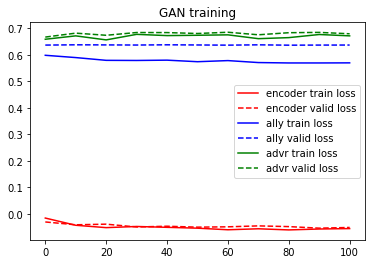

In [13]:
encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)

In [39]:
torch.save(encoder, 'checkpoints/mimic_encoder.pkl')

# Ally and Adversary Learning on Encoded Data

In [27]:
class Network(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.sigmoid(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [12]:
def train_ally(lr, n_epochs, debug=True):
    network = Network(X_train_reduced.shape[1], 128, 1).cuda()
    
    dataset_train = utils.TensorDataset(
        torch.Tensor(X_train_normalized), 
        torch.Tensor(y_ally_train.reshape(-1, 1)),
    )
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=False, num_workers=2)

    dataset_valid = utils.TensorDataset(
        torch.Tensor(X_valid_normalized),
        torch.Tensor(y_ally_valid.reshape(-1, 1)),
    )
    dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)


    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network.parameters(), lr=lr)    

    if debug:
        print("epoch \t ally_train \t ally_valid")

    n_epoch = []
    train = []
    valid = []
    network.train()
            
    for epoch in range(n_epochs):
        for i, data in enumerate(dataloader_train, 0):
            X_train_torch = data[0].to(device)
            y_ally_train_torch = data[1].to(device)
            net_optimizer.zero_grad()
            
            X_train_encoded = encoder(X_train_torch)

            y_ally_train_torch_hat = network(X_train_encoded)
            loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
            loss.backward()
            net_optimizer.step()

        if (epoch)%(int(n_epochs/10))!=0:
            continue

        nsamples = 0
        ally_valid_loss = 0
        for i, data in enumerate(dataloader_valid, 0):
            X_valid_torch = data[0].to(device)
            y_ally_valid_torch = data[1].to(device)
            
            X_valid_encoded = encoder(X_valid_torch)
            
            y_ally_valid_torch_hat = network(X_valid_encoded)
            ally_valid_loss += criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
            nsamples += 1

        if debug:
            print('{} \t {:.8f} \t {:.8f}'.format(
                epoch,  
                loss.item(),
                ally_valid_loss/nsamples
            ))

        n_epoch.append(epoch)
        train.append(loss.item())
        valid.append(ally_valid_loss/nsamples)
    return n_epoch, train, valid

In [24]:
lr_ally = 0.0001
n_epochs = 501

In [31]:
n_epoch, gan_train_ally, gan_valid_ally = train_ally(lr_ally, n_epochs)

epoch 	 ally_train 	 ally_valid
0 	 0.67529058 	 0.68115729
50 	 0.61590689 	 0.64312488
100 	 0.61408687 	 0.64360666
150 	 0.61357498 	 0.64375609
200 	 0.61319494 	 0.64389753
250 	 0.61295819 	 0.64402878
300 	 0.61282307 	 0.64411175
350 	 0.61270720 	 0.64415175
400 	 0.61260170 	 0.64415908
450 	 0.61251676 	 0.64415282
500 	 0.61244959 	 0.64413780


In [13]:
def train_advr(lr, n_epochs, debug=True):
    network_advr = Network(X_train_reduced.shape[1], 128, 1).cuda()
    
    dataset_train = utils.TensorDataset(
        torch.Tensor(X_train_normalized), 
        torch.Tensor(y_advr_train.reshape(-1, 1)))
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=False, num_workers=2)

    dataset_valid = utils.TensorDataset(
        torch.Tensor(X_valid_normalized),
        torch.Tensor(y_advr_valid.reshape(-1, 1))
    )
    dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=256, shuffle=False, num_workers=2)

    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_advr.parameters(), lr=lr)    

    if debug:
        print("epoch \t advr_train \t advr_valid")

    train_a = []
    valid_a = []
    network_advr.train()

    for epoch in range(n_epochs):
        
        for i, data in enumerate(dataloader_train, 0):
            X_train_torch = data[0].to(device)
            y_advr_train_torch = data[1].to(device)
            net_optimizer.zero_grad()
            
            X_train_encoded = encoder(X_train_torch)

            y_advr_train_torch_hat = network_advr(X_train_encoded)
            loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
            loss.backward()
            net_optimizer.step()

        if (epoch)%(int(n_epochs/10))!=0:
            continue

        nsamples = 0
        advr_valid_loss = 0
        for i, data in enumerate(dataloader_valid, 0):
            X_valid_torch = data[0].to(device)
            y_advr_valid_torch = data[1].to(device)
            
            X_valid_encoded = encoder(X_valid_torch)
            
            y_advr_valid_torch_hat = network_advr(X_valid_encoded)
            advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)

        if debug:
            print('{} \t {:.8f} \t {:.8f}'.format(
                epoch,  
                loss.item(),
                advr_valid_loss.item()
            ))
        train_a.append(loss.item())
        valid_a.append(advr_valid_loss.item())
    return train_a, valid_a

In [25]:
lr_advr = 0.001
n_epochs = 501

In [ ]:
gan_train_advr, gan_valid_advr = train_advr(lr_advr, n_epochs)

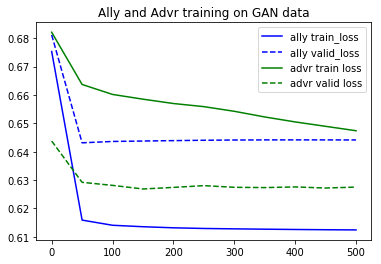

In [34]:
plt.plot(n_epoch, gan_train_ally, 'b')
plt.plot(n_epoch, gan_valid_ally, 'b--')
plt.plot(n_epoch, gan_train_advr, 'g')
plt.plot(n_epoch, gan_valid_advr, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on GAN data")
plt.show()

In [40]:
pkl.dump(
    (n_epoch, gan_valid_ally, gan_valid_advr), 
    open('checkpoints/mimic_learning_over_gan_encoded_n_epoch_valid_ally_advr.pkl', 'wb')
)

# Variation over Alpha

In [9]:
alphas = [0, 0.25, 0.5, 0.75, 1]

0


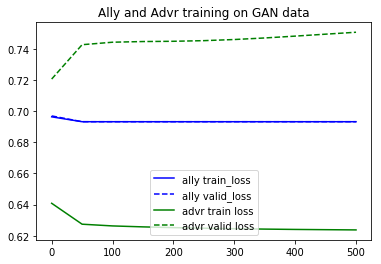

0.25


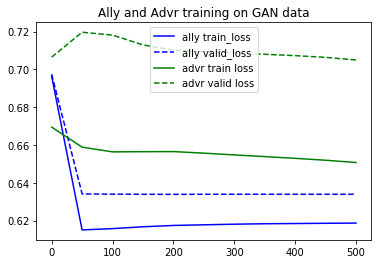

0.5


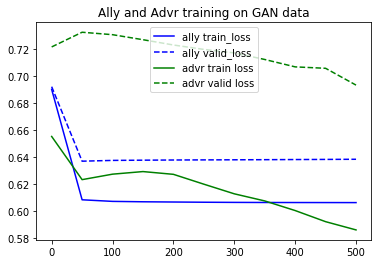

0.75


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 3.95 GiB total capacity; 2.46 GiB already allocated; 8.12 MiB free; 79.92 MiB cached)

In [29]:
gan_ally_over_alpha = [0, 0, 0, 0, 0]
gan_advr_over_alpha = [0, 0, 0, 0, 0]
average_over = 10
for i in range(average_over):
    for idx, alpha in enumerate(alphas):
        print("="*80)
        print(alpha)
        print("="*80)
        encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=False, debug=False)
        n_epoch, gan_train_ally, gan_valid_ally = train_ally(lr_ally, n_epochs, debug=False)
        gan_train_advr, gan_valid_advr = train_advr(lr_advr, n_epochs, False)
        gan_ally_over_alpha[idx] = i * gan_ally_over_alpha[idx] + gan_valid_ally[-1]
        gan_advr_over_alpha[idx] = i * gan_advr_over_alpha[idx] + gan_valid_advr[-1]
        plt.plot(n_epoch, gan_train_ally, 'b')
        plt.plot(n_epoch, gan_valid_ally, 'b--')
        plt.plot(n_epoch, gan_train_advr, 'g')
        plt.plot(n_epoch, gan_valid_advr, 'g--')
        plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
        plt.title("Ally and Advr training on GAN data")
        plt.show()
    gan_ally_over_alpha = [_/(i+1) for _ in gan_ally_over_alpha]
    gan_advr_over_alpha = [_/(i+1) for _ in gan_advr_over_alpha]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    print("="*80)
    print("Comparison")
    print("="*80)
    plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
    plt.xlabel('ally')
    plt.ylabel('advr')
    plt.title('Comparison after {} average'.format(i+1))
    for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
        ax.annotate('%s' % label, xy=xy, textcoords='data')
    plt.show()

# Ally and Adversary Learning on DP Data

In [ ]:
def laplaceMechanism(x, epsilon):
    x +=  torch.Tensor(np.random.laplace(0, 1.0/epsilon, x.shape)).cuda()
    return x

In [ ]:
epsilon = 1

In [ ]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

lr = 0.001

network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

dp_ally_train = []
dp_ally_valid = []

X_train_pca_torch = X_train_pca_torch.to(device)
X_valid_pca_torch = X_valid_pca_torch.to(device)
y_ally_train_torch = y_ally_train_torch.to(device)
y_ally_valid_torch = y_ally_valid_torch.to(device)

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
    
    y_ally_train_torch_hat = network_ally_pca(X_train_iter)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    dp_ally_train.append(loss.item())
    dp_ally_valid.append(ally_valid_loss)

In [ ]:
lr = 0.0001

network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

y_advr_train_torch = y_advr_train_torch.to(device)
y_advr_valid_torch = y_advr_valid_torch.to(device)

dp_advr_train = []
dp_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
    y_advr_train_torch_hat = network_advr_pca(X_train_iter)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    dp_advr_train.append(loss.item())
    dp_advr_valid.append(advr_valid_loss.item())

In [ ]:
plt.plot(n_epoch, dp_ally_train, 'b')
plt.plot(n_epoch, dp_ally_valid, 'b--')
plt.plot(n_epoch, dp_advr_train, 'g')
plt.plot(n_epoch, dp_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on DP data")
plt.show()

In [ ]:
[1, 26, 51, 71, 101,]

In [3]:
ally_dp_over_epsilons = []
advr_dp_over_epsilons = []
for epsilon in epsilons:
    X_train_pca_torch = torch.Tensor(X_train_reduced)
    X_valid_pca_torch = torch.Tensor(X_valid_reduced)

    lr = 0.001

    network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

    X_train_pca_torch = X_train_pca_torch.to(device)
    X_valid_pca_torch = X_valid_pca_torch.to(device)
    y_ally_train_torch = y_ally_train_torch.to(device)
    y_ally_valid_torch = y_ally_valid_torch.to(device)

    for epoch in range(501):
        network_ally_pca.train()
        net_optimizer.zero_grad()

        X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)

        y_ally_train_torch_hat = network_ally_pca(X_train_iter)
        loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)

    ally_dp_over_epsilons.append(ally_valid_loss.item())
    print(epsilon, loss.item(), ally_valid_loss.item())

    lr = 0.001

    network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

    y_advr_train_torch = y_advr_train_torch.to(device)
    y_advr_valid_torch = y_advr_valid_torch.to(device)


    for epoch in range(501):
        network_advr_pca.train()
        net_optimizer.zero_grad()

        X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
        y_advr_train_torch_hat = network_advr_pca(X_train_iter)
        loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)

    print(epsilon, loss.item(), advr_valid_loss.item())
    advr_dp_over_epsilons.append(advr_valid_loss.item())

NameError: name 'torch' is not defined

# Ally and Adversary Learning on PCA Data

In [53]:
X_train_pca_torch = torch.Tensor(X_train_reduced).to(device)
X_valid_pca_torch = torch.Tensor(X_valid_reduced).to(device)

In [54]:
lr = 0.01

network_ally_pca = Network(X_train_reduced.shape[1], 64, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")


pca_ally_train = []
pca_ally_valid = []

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_pca(X_train_pca_torch)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss.item()
    ))
    
    
    pca_ally_train.append(loss.item())
    pca_ally_valid.append(ally_valid_loss.item())

epoch 	 ally_train 	 ally_valid
0 	 0.78447592 	 0.76027727
50 	 0.64781976 	 0.64625418
100 	 0.63794595 	 0.63700974
150 	 0.63554275 	 0.63523686
200 	 0.63348424 	 0.63429958
250 	 0.63181156 	 0.63412553
300 	 0.63016522 	 0.63395625
350 	 0.62858170 	 0.63375074
400 	 0.62709183 	 0.63340187
450 	 0.62562925 	 0.63345551
500 	 0.62425476 	 0.63348293


In [55]:
lr = 0.001

network_advr_pca = Network(X_train_reduced.shape[1], 64, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

pca_advr_train = []
pca_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_pca(X_train_pca_torch)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    
    pca_advr_train.append(loss.item())
    pca_advr_valid.append(advr_valid_loss.item())

epoch 	 advr_train 	 advr_valid
0 	 0.69361693 	 0.69301516
50 	 0.67806548 	 0.67850947
100 	 0.67097455 	 0.67147344
150 	 0.66637093 	 0.66702551
200 	 0.66412127 	 0.66502994
250 	 0.66296226 	 0.66411495
300 	 0.66214287 	 0.66356122
350 	 0.66133773 	 0.66311586
400 	 0.66043490 	 0.66273952
450 	 0.65942872 	 0.66238576
500 	 0.65832710 	 0.66205692


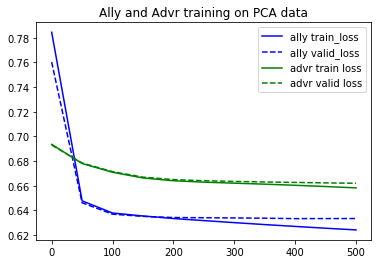

In [56]:
plt.plot(n_epoch, pca_ally_train, 'b')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_train, 'g')
plt.plot(n_epoch, pca_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on PCA data")
plt.show()

# Ally and Adversary Training on Auto-encoded data

In [57]:
lr = 0.01

network_ally_ae = Network(X_train_reduced.shape[1], 64, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_ae.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")


ae_ally_train=[]
ae_ally_valid = []

for epoch in range(501):
    network_ally_ae.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_ae(X_train_torch_ae)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_ae.eval()
    y_ally_valid_torch_hat = network_ally_ae(X_valid_torch_ae)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    ae_ally_train.append(loss.item())
    ae_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.82732135 	 0.74306822
50 	 0.69205374 	 0.69193101
100 	 0.64882946 	 0.64533114
150 	 0.63756657 	 0.63600445
200 	 0.63588375 	 0.63520581
250 	 0.63475424 	 0.63470906
300 	 0.63382542 	 0.63436699
350 	 0.63297707 	 0.63413721
400 	 0.63215852 	 0.63399160
450 	 0.63138366 	 0.63387173
500 	 0.63064879 	 0.63374639


In [58]:
lr = 0.001

network_advr_ae = Network(X_train_reduced.shape[1], 64, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_ae.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

ae_advr_train = []
ae_advr_valid = []
for epoch in range(501):
    network_advr_ae.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_ae(X_train_torch_ae)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_ae.eval()
    y_advr_valid_torch_hat = network_advr_ae(X_valid_torch_ae)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    ae_advr_train.append(loss.item())
    ae_advr_valid.append(advr_valid_loss.item())

epoch 	 advr_train 	 advr_valid
0 	 0.70922893 	 0.70561129
50 	 0.68192327 	 0.68233502
100 	 0.67384440 	 0.67458069
150 	 0.66870427 	 0.66944379
200 	 0.66620702 	 0.66697294
250 	 0.66474456 	 0.66568464
300 	 0.66365075 	 0.66486293
350 	 0.66273999 	 0.66427588
400 	 0.66194612 	 0.66381216
450 	 0.66122341 	 0.66342491
500 	 0.66053635 	 0.66308683


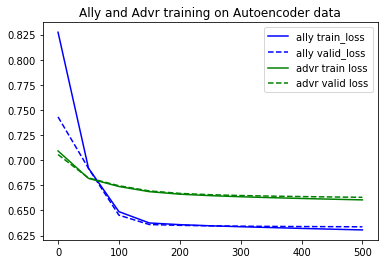

In [59]:
plt.plot(n_epoch, ae_ally_train, 'b')
plt.plot(n_epoch, ae_ally_valid, 'b--')
plt.plot(n_epoch, ae_advr_train, 'g')
plt.plot(n_epoch, ae_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on Autoencoder data")
plt.show()

# Results

| Model | Train Ally  | Valid Ally  | Train Advr | Valid Advr |
|---|---:|---:|---:|---:|
| PCA | 0.62237549 | 0.63795388 | 0.65854299 | 0.66764313 |
| A-Enc | 0.62899935 | **0.63755053** | 0.65798354 | 0.66843909 |
| P-GAN | **0.61490375** | 0.63841212 | **0.68383056** | **0.68446696** |

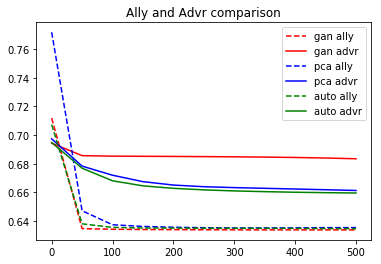

In [56]:
plt.plot(n_epoch, valid, 'r--')
plt.plot(n_epoch, valid_a, 'r')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_valid, 'b')
plt.plot(n_epoch, ae_ally_valid, 'g--')
plt.plot(n_epoch, ae_advr_valid, 'g')
plt.legend(['gan ally', 'gan advr', 'pca ally', 'pca advr', 'auto ally', 'auto advr'])
plt.title("Ally and Advr comparison")
plt.show()

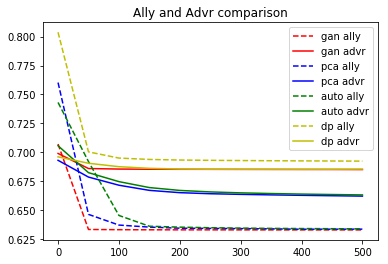

In [63]:
plt.plot(n_epoch, valid, 'r--')
plt.plot(n_epoch, valid_a, 'r')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_valid, 'b')
plt.plot(n_epoch, ae_ally_valid, 'g--')
plt.plot(n_epoch, ae_advr_valid, 'g')
plt.plot(n_epoch, dp_ally_valid, 'y--')
plt.plot(n_epoch, dp_advr_valid, 'y')
plt.legend(['gan ally', 'gan advr', 'pca ally', 'pca advr', 'auto ally', 'auto advr', 'dp ally', 'dp advr'])
plt.title("Ally and Advr comparison")
plt.show()